In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np 
import plotnine as pn 

Make sure to download clumps_count and the folder of the images of the clumps off of the google drive! 

In [30]:
# read in labels 
labels = pd.read_csv('clumps_count.csv')

In [31]:
labels.dropna(inplace=True) 

In [32]:
labels.head()

,clump,Number of Adult Female Seals,Number of Baby Seals,Number of Adult Male Seals,Total Number of Seals
0,LS21323_DJI_0001_clump_0001,1.0,1.0,0.0,2.0
1,LS21323_DJI_0001_clump_0002,4.0,4.0,0.0,8.0
2,LS21323_DJI_0001_clump_0003,4.0,5.0,0.0,9.0
3,LS21323_DJI_0001_clump_0004,1.0,1.0,0.0,2.0
4,LS21323_DJI_0001_clump_0005,1.0,1.0,0.0,2.0


In [33]:
labels['clump_name'] = labels['clump'].str[:-11]

In [34]:
labels['clump_name'].value_counts()

clump_name
LS21323_DJI_0843    54
LS21323_DJI_0011    41
LS21323_DJI_0842    41
LS21323_DJI_0010    39
LS21323_DJI_0013    36
LS21323_DJI_0012    34
LS21323_DJI_0009    33
LS21323_DJI_0837    33
LS21323_DJI_0015    31
LS21323_DJI_0014    31
LS21323_DJI_0838    30
LS21323_DJI_0850    30
LS21323_DJI_0844    24
LS21323_DJI_0002    23
LS21323_DJI_0835    23
LS21323_DJI_0841    21
LS21323_DJI_0008    21
LS21323_DJI_0834    20
LS21323_DJI_0001    20
LS21323_DJI_0003    17
LS21323_DJI_0839    17
LS21323_DJI_0005    17
LS21323_DJI_0836    13
LS21323_DJI_0007     9
LS21323_DJI_0851     9
LS21323_DJI_0840     8
LS21323_DJI_0004     7
LS21323_DJI_0006     4
LS21323_DJI_0019     4
LS21323_DJI_0017     3
LS21323_DJI_0020     3
LS21323_DJI_0021     3
LS21323_DJI_0016     2
LS21323_DJI_0018     2
LS21323_DJI_0022     1
Name: count, dtype: int64

In [35]:
len(labels)

704

In [36]:
# split 

# train_val_labels, test_labels = train_test_split(labels, test_size=1/5, random_state=452)

test_labels = labels[labels['clump_name'].isin(['LS21323_DJI_0002', 'LS21323_DJI_0837', 'LS21323_DJI_0836', 'LS21323_DJI_0007', 'LS21323_DJI_0839'])] # more specific test set
train_val_labels = labels[~labels['clump_name'].isin(['LS21323_DJI_0002', 'LS21323_DJI_0837', 'LS21323_DJI_0836', 'LS21323_DJI_0007', 'LS21323_DJI_0839'])]

train_labels, val_labels = train_test_split(train_val_labels, test_size=1/8, random_state=452)

In [37]:
train_imgs = train_labels['clump'].values
val_imgs = val_labels['clump'].values 
test_imgs = test_labels['clump'].values 

In [39]:
# preprocessing 
class SealDataset(Dataset): 
    def __init__(self, img_dir, img_ids, labels, transform_pipeline):
        self.img_dir = img_dir
        self.img_ids = img_ids 
        self.labels = labels 
        self.transform_pipeline = transform_pipeline

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        row = self.labels.iloc[idx]

        img_path = os.path.join(self.img_dir, f'{self.img_ids[idx]}.tif')
        image = self.transform_pipeline(Image.open(img_path).convert('RGB'))
        
        label = torch.tensor([
            row['Number of Adult Male Seals'], 
            row['Number of Adult Female Seals'],
            row['Number of Baby Seals']
        ], dtype=torch.float32)

        return image, label

In [40]:
# transformation pipeline 
transform_pl = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
# loading to class
# img_dir = '../../elephant-seals-image-extraction/scripts/clumps' # img dir of clump imgs on my pc 
img_dir = '../../clumps/clumps' # my laptop

train_set = SealDataset(img_dir, train_imgs, train_labels, transform_pl)
val_set = SealDataset(img_dir, val_imgs, val_labels, transform_pl)
test_set = SealDataset(img_dir, test_imgs, test_labels, transform_pl)

train_loader = DataLoader(train_set, batch_size=32)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

In [42]:
# model 
class SealCountRegressor(nn.Module):
    def __init__(self):
        super(SealCountRegressor, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Softplus()
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.regressor(features)

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [44]:
model = SealCountRegressor()
model = model.to(device) 

c:\Users\telec\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
c:\Users\telec\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


In [45]:
criterion = nn.PoissonNLLLoss(log_input=False) # poisson cuz count data 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [46]:
# model training 
for epoch in range(10):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) 

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()*images.size(0)

    print(f"Epoch {epoch+1} - Loss: {running_loss / len(train_loader.dataset):.4f}")

    model.eval()
    val_loss = 0 
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device) 

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
        
        print(f'Val Loss: {val_loss / len(val_loader):.4f}')

Epoch 1 - Loss: 0.7518
Val Loss: 0.5383
Epoch 2 - Loss: 0.5262
Val Loss: 0.4799
Epoch 3 - Loss: 0.4819
Val Loss: 0.4905
Epoch 4 - Loss: 0.4631
Val Loss: 0.4708
Epoch 5 - Loss: 0.4555
Val Loss: 0.4634
Epoch 6 - Loss: 0.4478
Val Loss: 0.4571
Epoch 7 - Loss: 0.4460
Val Loss: 0.4679
Epoch 8 - Loss: 0.4477
Val Loss: 0.4600
Epoch 9 - Loss: 0.4453
Val Loss: 0.4690
Epoch 10 - Loss: 0.4365
Val Loss: 0.4452


In [47]:
# eval
model.eval()
predicted_males = []
predicted_females = []
predicted_cubs = []

actual_males = []
actual_females = []
actual_cubs = [] 

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        outputs = model(images).cpu()

        for output, label in zip(outputs, labels): 

            predicted_males.append(output[0].item())
            predicted_females.append(output[1].item())
            predicted_cubs.append(output[2].item())

            actual_males.append(label[0].item())
            actual_females.append(label[1].item())
            actual_cubs.append(label[2].item())

predicted_males = np.array(predicted_males)
predicted_females = np.array(predicted_females)
predicted_cubs = np.array(predicted_cubs)
actual_males = np.array(actual_males)
actual_females = np.array(actual_females)
actual_cubs = np.array(actual_cubs)

mae_male = np.mean(np.abs(predicted_males - actual_males))
mae_female = np.mean(np.abs(predicted_females - actual_females))
mae_cubs = np.mean(np.abs(predicted_cubs - actual_cubs))

print(f"MAE - Adult Males:   {mae_male:.2f}")
print(f"MAE - Adult Females: {mae_female:.2f}")
print(f"MAE - Cubs:          {mae_cubs:.2f}")

MAE - Adult Males:   0.03
MAE - Adult Females: 0.27
MAE - Cubs:          0.25


In [49]:
pva = pd.DataFrame({
    'predicted_males': predicted_males, 
    'predicted_females': predicted_females, 
    'predicted_cubs': predicted_cubs,
    'actual_males': actual_males,
    'actual_females': actual_females,
    'actual_cubs': actual_cubs
})

In [57]:
results = pd.concat([test_labels.reset_index(), pva.reset_index()], axis=1)

In [ ]:
# macro measures 
results.groupby(['clump_name'])[['Number of Adult Female Seals', 'Number of Baby Seals', 
                                 'Number of Adult Male Seals', 'predicted_females',
                                 'predicted_cubs', 'predicted_males']].sum()

,Number of Adult Female Seals,Number of Baby Seals,Number of Adult Male Seals,predicted_females,predicted_cubs,predicted_males
clump_name,,,,,,
LS21323_DJI_0002,29.0,28.0,2.0,27.776067,26.130690,0.515761
LS21323_DJI_0007,9.0,8.0,1.0,11.335130,8.592986,0.379952
LS21323_DJI_0836,14.0,13.0,1.0,11.219274,11.050259,0.807270
LS21323_DJI_0837,42.0,44.0,1.0,34.473241,41.052149,0.486916
LS21323_DJI_0839,20.0,21.0,0.0,21.185536,19.411756,0.026232


In [ ]:
# "micro" measures 
results.groupby(['clump_name'])[['Number of Adult Female Seals', 'Number of Baby Seals', 
                                 'Number of Adult Male Seals', 'predicted_females',
                                 'predicted_cubs', 'predicted_males']].mean()

,Number of Adult Female Seals,Number of Baby Seals,Number of Adult Male Seals,predicted_females,predicted_cubs,predicted_males
clump_name,,,,,,
LS21323_DJI_0002,1.260870,1.217391,0.086957,1.207655,1.136117,0.022424
LS21323_DJI_0007,1.000000,0.888889,0.111111,1.259459,0.954776,0.042217
LS21323_DJI_0836,1.076923,1.000000,0.076923,0.863021,0.850020,0.062098
LS21323_DJI_0837,1.272727,1.333333,0.030303,1.044644,1.244005,0.014755
LS21323_DJI_0839,1.176471,1.235294,0.000000,1.246208,1.141868,0.001543


In [60]:
pva.groupby(['actual_females']).mean()['predicted_females']

actual_females
0.0    0.304391
1.0    0.974438
2.0    1.802047
3.0    2.220325
4.0    2.287552
Name: predicted_females, dtype: float64

In [62]:
pva.groupby(['actual_females']).size()

actual_females
0.0     8
1.0    67
2.0    15
3.0     3
4.0     2
dtype: int64

In [61]:
pva.groupby(['actual_cubs']).mean()['predicted_cubs']

actual_cubs
0.0    0.463448
1.0    0.980107
2.0    1.529280
3.0    2.478580
Name: predicted_cubs, dtype: float64

In [63]:
pva.groupby(['actual_cubs']).size()

actual_cubs
0.0     9
1.0    64
2.0    16
3.0     6
dtype: int64

In [66]:
females_long = pva[['predicted_females', 'actual_females']].melt(var_name = 'var', value_name = 'value')
cubs_long = pva[['predicted_cubs', 'actual_cubs']].melt(var_name = 'var', value_name = 'value')

c:\Users\telec\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 51'. Pick better value with 'binwidth'.


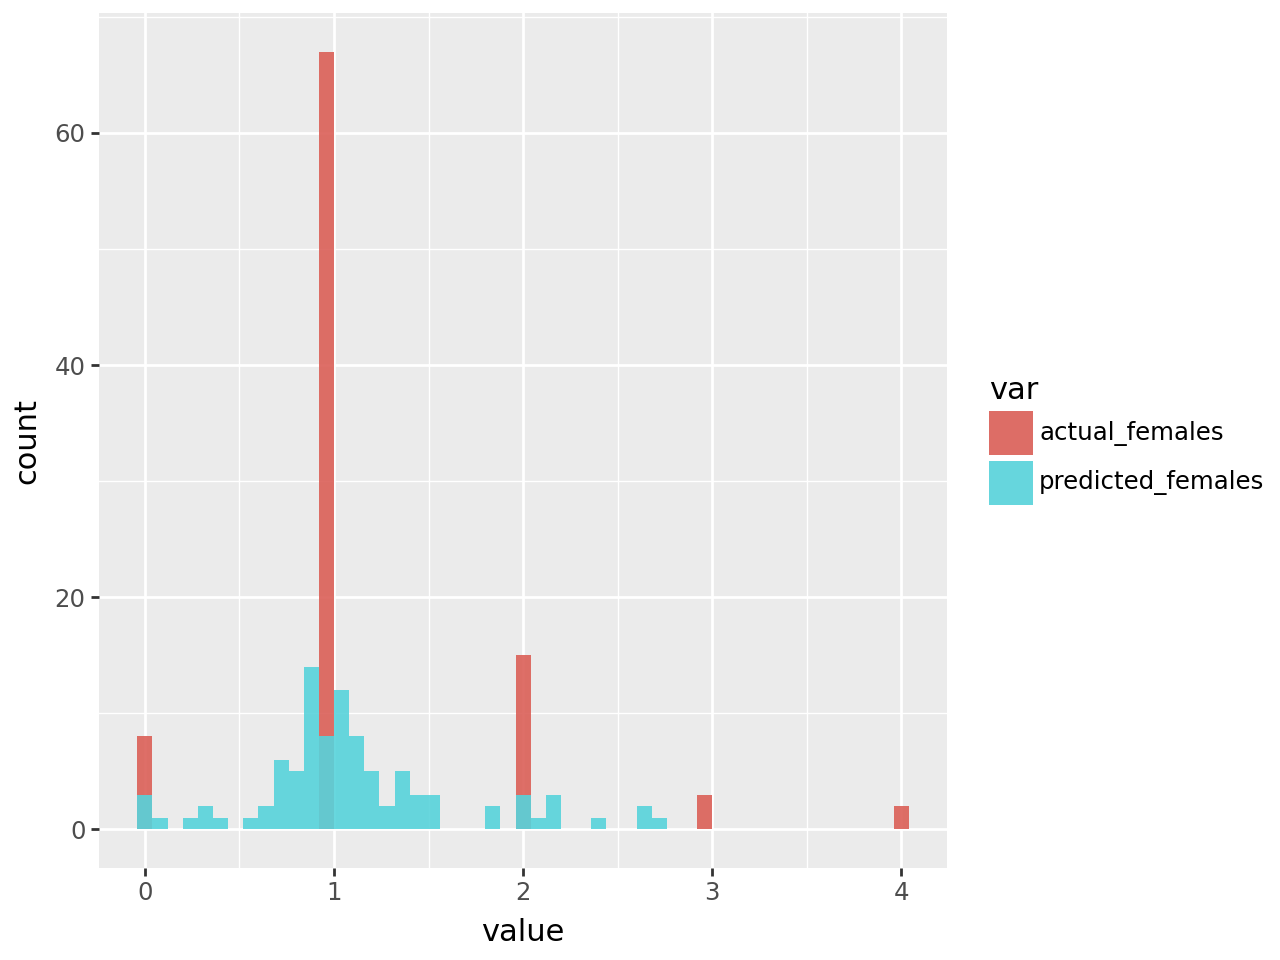

In [67]:
(
    pn.ggplot(females_long, pn.aes(x = 'value', fill = 'var')) +
    pn.geom_histogram(alpha=0.9, position= 'identity') 

)

c:\Users\telec\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 45'. Pick better value with 'binwidth'.


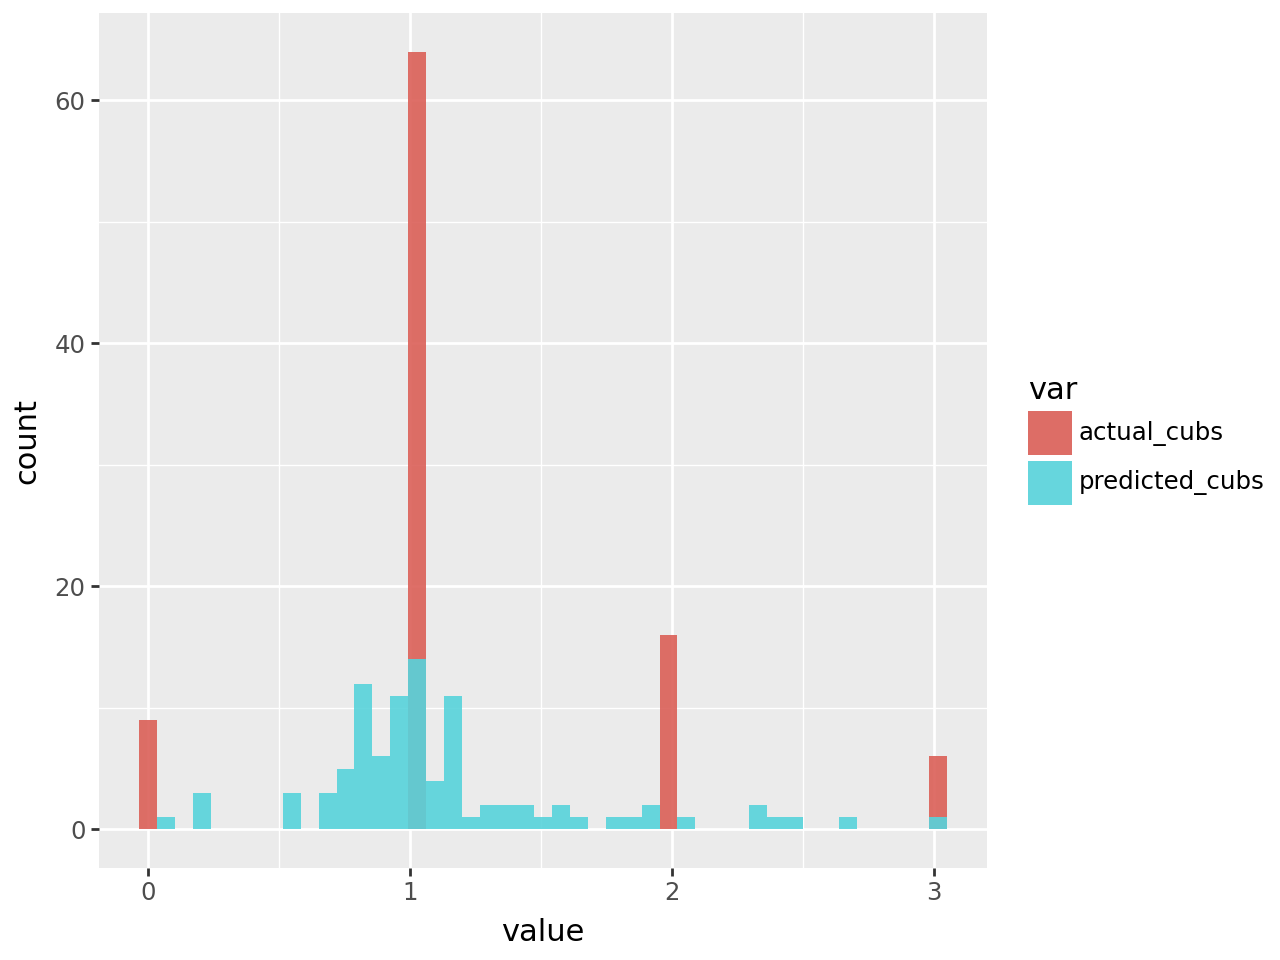

In [68]:
(
    pn.ggplot(cubs_long, pn.aes(x = 'value', fill = 'var')) +
    pn.geom_histogram(alpha=0.9, position= 'identity') 

)